# PROJECT : Mammogram Classification Using CNNs

DATASET: THE MIAS-MAMMOGRAPHY DATASET

INFORMATION:

This file lists the films in the MIAS database and provides     
appropriate details as follows:

1st column: MIAS database reference number.

2nd column: Character of background tissue: 
                F - Fatty 
                G - Fatty-glandular
                D - Dense-glandular

3rd column: Class of abnormality present:
                CALC - Calcification
                CIRC - Well-defined/circumscribed masses
                SPIC - Spiculated masses
                MISC - Other, ill-defined masses
                ARCH - Architectural distortion
                ASYM - Asymmetry
                NORM - Normal

4th column: Severity of abnormality;
                B - Benign
                M - Malignant
                
5th,6th columns: x,y image-coordinates of centre of abnormality.

7th column: Approximate radius (in pixels) of a circle enclosing
            the abnormality.
            
NOTES

1- The list is arranged in pairs of films, where each pair 
   represents the left (even filename numbers) and right mammograms
   (odd filename numbers) of a single patient.
   
2- The size of ALL the images is 1024 pixels x 1024 pixels. The images
   have been centered in the matrix.  

3- When calcifications are present, centre locations and radii 
   apply to clusters rather than individual calcifications.
   Coordinate system origin is the bottom-left corner.

4- In some cases calcifications are widely distributed throughout
   the image rather than concentrated at a single site. In these
   cases centre locations and radii are inappropriate and have
   been omitted.

### Importing Libraries

In [1]:
# system related
import os
import sys
sys.path.append('../src/')
# import custom modules
from modules import helpers as hp
from modules import mammoscan as ms

# path manipulation
from pathlib import Path

# regex
import re

# plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle

# data manipulation / preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image manipulation
from PIL import Image
from IPython.display import Image

# metrics
from sklearn.metrics import confusion_matrix, classification_report


# keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

### Data Collection

#### Get the scans data

In [2]:
mias = hp.create_mias_dataset('../scan_file_data.txt')
mias

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,A,NaN,NaN,NaN
mdb004,D,NORM,A,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...
mdb318,D,NORM,A,NaN,NaN,NaN
mdb319,D,NORM,A,NaN,NaN,NaN
mdb320,D,NORM,A,NaN,NaN,NaN


### Data Preparation / Augmentation

This process takes the original images (1024x1024) and generates rotated and mirrored subsamples of them. 

The subsamples generated by this process have size (48x48) and rotated versions by 0, 90, 180, 270 degrees.

There also are top/bottom and right/left mirrored versions of the original images.

Originally, the clean dataset has 319 images. 

The transformation process produces 3828 images. 

That is to say that for each image, 12 new images are created or a 1200% increase.

In [3]:
mias = hp.generate_subsamples('../all-mias/', mias)

In [4]:
mias

,ab_class,bg,p_matrix,severity,subsample_path
mdb001_0_rotated,CIRC,G,"[[1, 4, 6, 9, 12, 15, 18, 24, 29, 35, 41, 48, ...",B,../subsamples/mdb001_0_rotated.png
mdb001_0_mirr_lr,CIRC,G,"[[121, 105, 113, 127, 136, 141, 139, 141, 142,...",B,../subsamples/mdb001_0_mirr_lr.png
mdb001_0_mirr_tp,CIRC,G,"[[0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 6, 7, 8, 10, 1...",B,../subsamples/mdb001_0_mirr_tp.png
mdb001_90_rotated,CIRC,G,"[[121, 110, 96, 98, 98, 99, 107, 130, 139, 127...",B,../subsamples/mdb001_90_rotated.png
mdb001_90_mirr_lr,CIRC,G,"[[62, 74, 77, 74, 75, 90, 109, 115, 125, 116, ...",B,../subsamples/mdb001_90_mirr_lr.png
...,...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,"[[198, 196, 200, 205, 208, 209, 208, 206, 204,...",A,../subsamples/mdb322_180_mirr_lr.png
mdb322_180_mirr_tp,NORM,D,"[[206, 206, 207, 204, 203, 202, 199, 194, 189,...",A,../subsamples/mdb322_180_mirr_tp.png
mdb322_270_rotated,NORM,D,"[[198, 196, 194, 192, 192, 193, 195, 194, 195,...",A,../subsamples/mdb322_270_rotated.png
mdb322_270_mirr_lr,NORM,D,"[[179, 177, 177, 178, 178, 178, 180, 184, 185,...",A,../subsamples/mdb322_270_mirr_lr.png


#### Data Distribution

The NORM class, which accounts for the scans with no abnormalities, stands for 64.8% of the scan samples. Its severity was defined as 'A' and it happens during the creation of the mias dataframe.

There is also a slight difference between Malign (M) and Benign (B) samples in all classes

The strategy to atenuate such disparity is to randomly remove whichever class is predominant (either M or N) so that we can have a balanced set. Classes to be balanced prior to be tested to ensure randomness.

As for the NORM class, it will reduced, also randomly, to the average of the samples for each class

In [5]:
mias.groupby(['ab_class']).severity.value_counts() / len(mias.index)

ab_class  severity
ARCH      M           0.031348
          B           0.028213
ASYM      M           0.028213
          B           0.018809
CALC      B           0.037618
          M           0.031348
CIRC      B           0.059561
          M           0.012539
MISC      B           0.021944
          M           0.021944
NORM      A           0.648903
SPIC      B           0.034483
          M           0.025078
Name: severity, dtype: float64

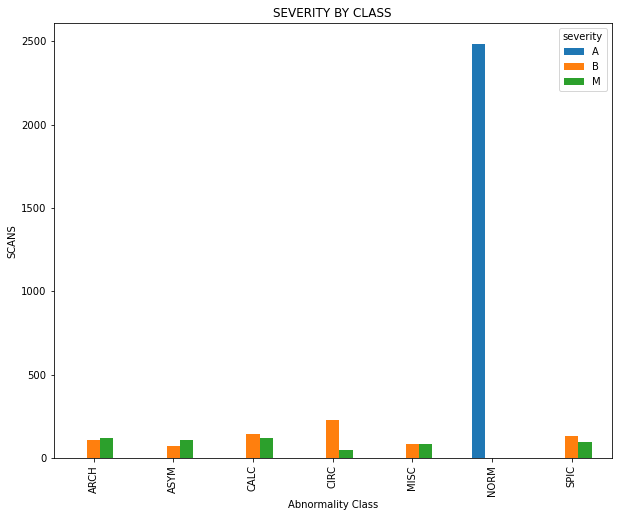

In [6]:
mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                               figsize=(10, 8), 
                                                               xlabel='Abnormality Class', 
                                                               ylabel='SCANS',
                                                               title='SEVERITY BY CLASS');


Abnormalities only

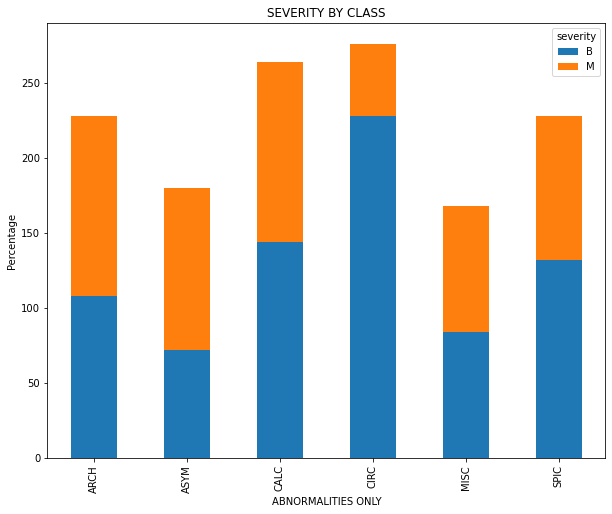

In [7]:
mias[mias.ab_class != 'NORM'].groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                                                      stacked=True, 
                                                                                      figsize=(10, 8), 
                                                                                      xlabel='ABNORMALITIES ONLY', 
                                                                                      ylabel='Percentage',
                                                                                      title='SEVERITY BY CLASS');

#### Dataset balancing Example

Calcifications before balancing

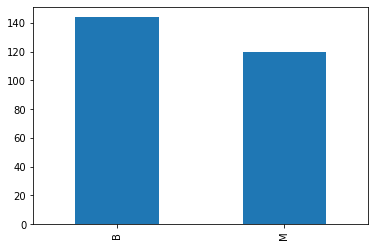

In [8]:
calcifications_unbalanced = mias[mias.ab_class == 'CALC']

calcifications_unbalanced.severity.value_counts().plot(kind='bar');

Calcifications after balancing

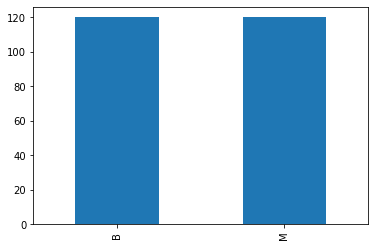

In [9]:
calcifications_balanced = hp.balance_by_severity(mias, 'CALC')

calcifications_balanced.severity.value_counts().plot(kind='bar');

#### Final Results Dataset

In [10]:
final_results = hp.create_final_results_df()

### TRAIN AND EVALUATE MODEL FOR CALCIFICATIONS

In [11]:
calcifications = hp.balance_by_severity(mias, 'CALC')
calcifications

,ab_class,bg,p_matrix,severity,subsample_path
mdb252_0_mirr_lr,CALC,F,"[[169, 168, 170, 170, 169, 163, 163, 163, 161,...",B,../subsamples/mdb252_0_mirr_lr.png
mdb223_270_rotated,CALC,D,"[[152, 154, 151, 148, 146, 150, 152, 156, 156,...",B,../subsamples/mdb223_270_rotated.png
mdb219_90_mirr_tp,CALC,G,"[[104, 103, 105, 106, 107, 108, 108, 110, 111,...",B,../subsamples/mdb219_90_mirr_tp.png
mdb223_270_mirr_tp,CALC,D,"[[165, 164, 165, 163, 162, 161, 161, 162, 159,...",B,../subsamples/mdb223_270_mirr_tp.png
mdb219_0_mirr_tp,CALC,G,"[[155, 158, 159, 157, 157, 159, 159, 163, 164,...",B,../subsamples/mdb219_0_mirr_tp.png
...,...,...,...,...,...
mdb256_180_mirr_lr,CALC,F,"[[160, 161, 161, 161, 161, 159, 157, 158, 161,...",M,../subsamples/mdb256_180_mirr_lr.png
mdb256_180_mirr_tp,CALC,F,"[[162, 159, 158, 160, 159, 161, 161, 161, 159,...",M,../subsamples/mdb256_180_mirr_tp.png
mdb256_270_rotated,CALC,F,"[[160, 160, 161, 159, 163, 165, 162, 159, 160,...",M,../subsamples/mdb256_270_rotated.png
mdb256_270_mirr_lr,CALC,F,"[[173, 171, 169, 170, 173, 171, 167, 170, 168,...",M,../subsamples/mdb256_270_mirr_lr.png


In [12]:
calcifications = calcifications.sample(len(calcifications), replace=False)

#### Generate Train and Test Data

In [13]:
data_generator = ImageDataGenerator(validation_split=.25, 
                                    height_shift_range=.10, 
                                    width_shift_range=.10, 
                                    rotation_range=30, 
                                    rescale=1/255.)

# train data
train_data = data_generator.flow_from_dataframe(calcifications, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)

# test data
test_data = data_generator.flow_from_dataframe(calcifications, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

Found 180 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


#### Create Convolutional Neural Network

In [14]:
cnn_calc = Sequential()
# first layer
cnn_calc.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))

cnn_calc.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
cnn_calc.add(MaxPool2D(pool_size=(2, 2)))
cnn_calc.add(Dropout(0.25))
# Add dense layer to reduce the number of features
cnn_calc.add(Dense(64, activation='relu'))
cnn_calc.add(Dropout(0.25))
# flattening results
cnn_calc.add(Flatten())
# Dense layer to produce final output
cnn_calc.add(Dense(2, activation='softmax'))
# print summary
cnn_calc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 10, 10, 64)        4

#### Visualise the Model's Structure


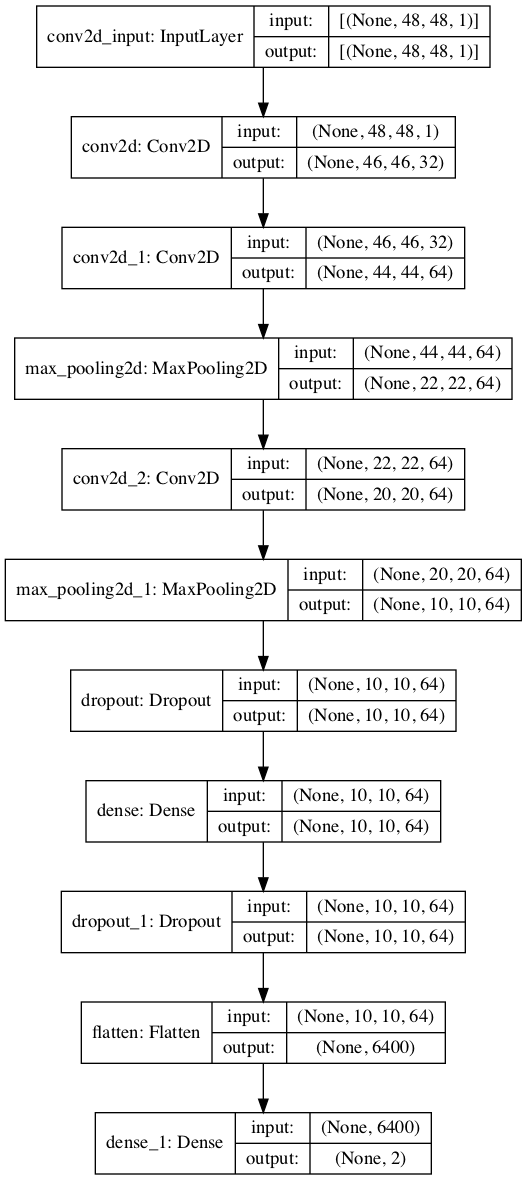

In [15]:
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

#### Compiling the model

In [16]:
adam = Adam(0.001)
cnn_calc.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [17]:
# set callbacks
early_stopping = EarlyStopping(patience=100, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# fit the model
hist = cnn_calc.fit(train_data, 
                    validation_data=test_data, 
                    epochs=100,
                    callbacks=[early_stopping, model_check_point])

Epoch 1/50
6/6 [==============================] - 2s 269ms/step - loss: 0.7032 - accuracy: 0.5407 - val_loss: 0.6932 - val_accuracy: 0.5667

Epoch 00001: val_loss improved from inf to 0.69320, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 2/50
6/6 [==============================] - 1s 155ms/step - loss: 0.6897 - accuracy: 0.5991 - val_loss: 0.6923 - val_accuracy: 0.5667

Epoch 00002: val_loss improved from 0.69320 to 0.69227, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 3/50
6/6 [==============================] - 1s 148ms/step - loss: 0.6989 - accuracy: 0.4651 - val_loss: 0.6914 - val_accuracy: 0.5167

Epoch 00003: val_loss improved from 0.69227 to 0.69137, saving model to ./
INFO:tensorflow:Assets written to: ./assets
Epoch 4/50
6/6 [==============================] - 1s 160ms/step - loss: 0.6919 - accuracy: 0.5676 - val_loss: 0.6889 - val_accuracy: 0.5667

Epoch 00004: val_loss improved from 0.69137 to 0.68888, saving model to ./
INFO:ten

#### Making predictions

In [22]:
# predictions
predictions = cnn_calc.predict(test_data)
predicted = [np.argmax(w) for w in predictions]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = cnn_calc.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

6/6 [==============================] - 0s 41ms/step - loss: 0.6114 - accuracy: 0.6000
Test loss_value: 0.6114108562469482
Test accuracy: 0.6000000238418579


#### Confusion Matrix

In [23]:
confusion_matrix(expected, predicted)

array([[11, 20],
       [ 2, 27]])

#### Classification Report

In [20]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

Classes: {'B': 0, 'M': 1}

              precision    recall  f1-score   support

           0       0.85      0.35      0.50        31
           1       0.57      0.93      0.71        29

    accuracy                           0.63        60
   macro avg       0.71      0.64      0.61        60
weighted avg       0.71      0.63      0.60        60



#### Results

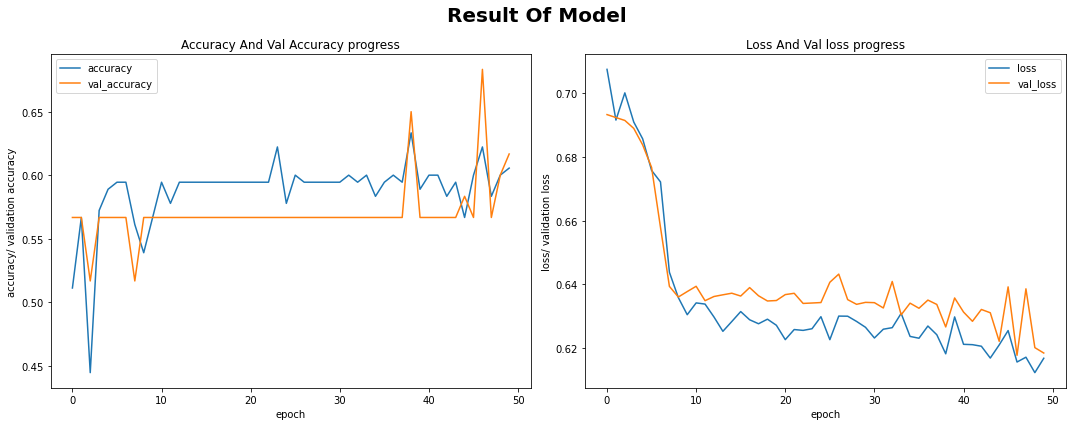

In [21]:
results_plot = hp.plot_results(hist.history['accuracy'],
                            hist.history['val_accuracy'], 
                            hist.history['loss'], 
                            hist.history['val_loss'])

# enter data to the final results dataframe
results_calc = classification_report(expected, predicted, output_dict=True)

In [52]:
calc_malignant = results_calc['1']
calc_malignant
final_results['calcifications'] = (calc_malignant['precision'], 
                                   calc_malignant['recall'], 
                                   calc_malignant['f1-score'], 
                                   calc_malignant['support'])
final_results

ValueError: Length of values (4) does not match length of index (1)

#### Checking Wrong Predictions

In [22]:
# checking wrong predictions
predictions = cnn_calc.predict(test_data)

# check the probabilities for the first sample
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')


0: 46.5935707092%
1: 53.4064292908%


In [23]:
images = calcifications.p_matrix

In [24]:
wrong_predictions = []

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)
    # create something to keep the same index from calcifications_balanced
    # and wrong predictions
    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [25]:
len(wrong_predictions)

44

In [26]:
a,b,c,d = wrong_predictions[4]

In [27]:
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')

In [28]:
hp.display_probabilities(predictions[4])

0: 41.2939578295%
1: 58.7060451508%


In [29]:
test = calcifications.iloc[a].loc['p_matrix'] == b

In [30]:
np.unique(test)

array([ True])

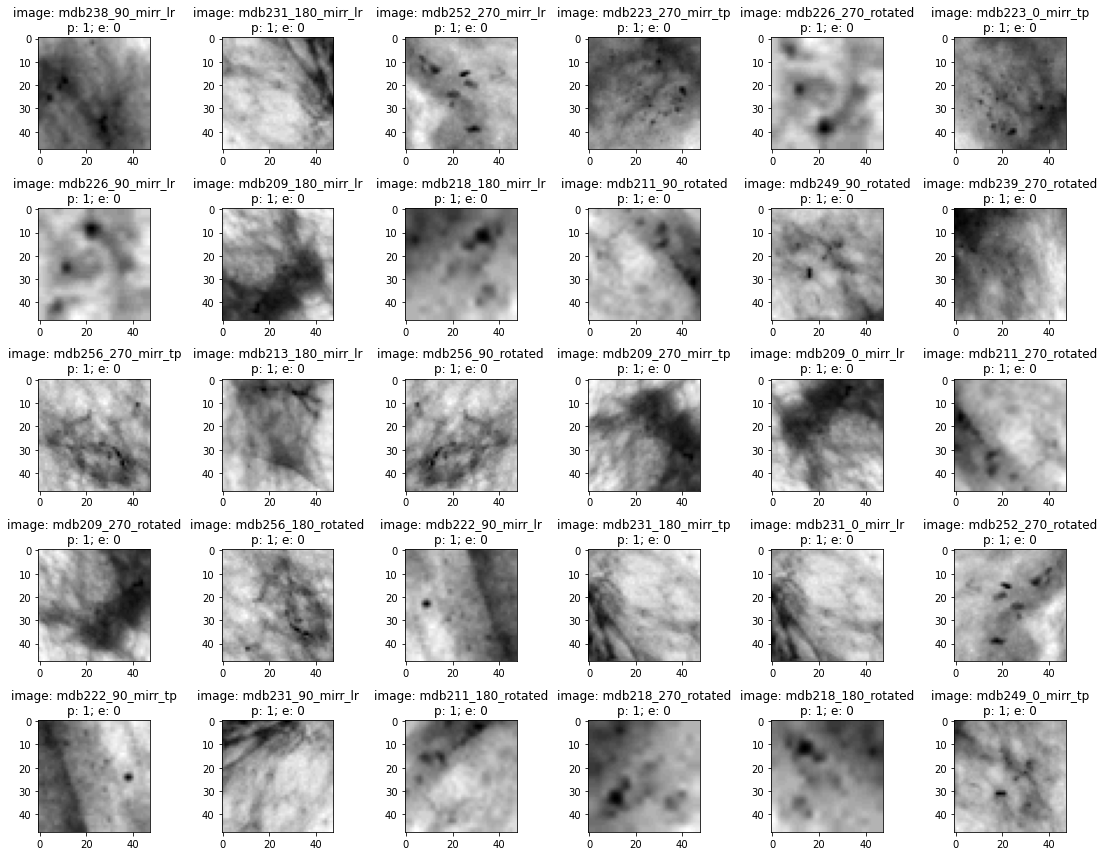

In [31]:
figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {calcifications.iloc[index].name}\np: {predicted}; e: {expected}'                   
                   )
    plt.tight_layout()

### TRAIN AND EVALUATE MODEL FOR MASSES

In [ ]:
# prepare dataset
circ_balanced = hp.balance_by_severity(mias, 'CIRC')
spic_balanced = hp.balance_by_severity(mias, 'SPIC')
misc_balanced = hp.balance_by_severity(mias, 'MISC')
# shuffle using the length of the smallest sample (CIRC)
circ_balanced = circ_balanced.sample(len(circ_balanced), replace=False)
spic_balanced = spic_balanced.sample(len(circ_balanced), replace=False)
misc_balanced = misc_balanced.sample(len(circ_balanced), replace=False)
# create new dataframe for the masses only
masses_balanced = pd.concat([circ_balanced, spic_balanced])
masses_balanced = pd.concat([masses_balanced, misc_balanced])
# masses dataset
masses_balanced = masses_balanced.sample(len(masses_balanced), replace=False)
masses_balanced

#### Check Balancing

In [ ]:
masses_balanced.groupby('ab_class').severity.value_counts()

In [ ]:
masses_balanced.groupby(['ab_class', 'severity']).severity.size().unstack().plot(kind='bar', 
                                                                      stacked=True, 
                                                                      figsize=(10, 8), 
                                                                      xlabel='Abnormality Class', 
                                                                      ylabel='Percentage',
                                                                      title='SEVERITY BY CLASS');

#### Generate Train and Test Data

In [ ]:
data_generator = ImageDataGenerator(validation_split=.25, 
                                    height_shift_range=.10, 
                                    width_shift_range=.10, 
                                    rotation_range=30, 
                                    rescale=1/255.)

train_data = data_generator.flow_from_dataframe(masses_balanced, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(masses_balanced, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

#### Create Convolutional Neural Network

In [ ]:
mass_cnn = Sequential()
# first layer
mass_cnn.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
mass_cnn.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
mass_cnn.add(MaxPool2D(pool_size=(2, 2)))

mass_cnn.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
mass_cnn.add(MaxPool2D(pool_size=(2, 2)))
mass_cnn.add(Dropout(0.25))
# Add dense layer to reduce the number of features
mass_cnn.add(Dense(64, activation='relu'))
mass_cnn.add(Dropout(0.25))
# flattening results
mass_cnn.add(Flatten())
# Dense layer to produce final output
mass_cnn.add(Dense(2, activation='softmax'))
# print summary
mass_cnn.summary()

#### Visualise the Model's Structure

In [ ]:
plot_model(mass_cnn, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

#### Compiling the model

In [ ]:
# # set optmizer and learning rate
adam = Adam(0.001)
mass_cnn.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# set callbacks
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# fit the model
hist = mass_cnn.fit(train_data, 
                    validation_data=test_data, 
                    epochs=50,
                    callbacks=[early_stopping, model_check_point])

#### Making Predictions

In [ ]:
y_pred = mass_cnn.predict(test_data)
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [ ]:
# predictions
predictions = mass_cnn.predict(test_data)
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = mass_cnn.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

#### Confusion Matrix

In [ ]:
confusion_matrix(expected, predicted)

#### Classification Report

In [ ]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

#### Results

In [ ]:
results_plot = hp.plot_results(hist.history['accuracy'],
                               hist.history['val_accuracy'], 
                               hist.history['loss'], 
                               hist.history['val_loss'])

#### Checking Wrong Predictions

In [ ]:
# checking wrong predictions
predictions = mass_cnn.predict(test_data)

# check the probabilities for the first sample
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')


In [ ]:
images = masses_balanced.p_matrix

In [ ]:
wrong_predictions = []

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)
    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [ ]:
len(wrong_predictions)

In [ ]:
a,b,c,d = wrong_predictions[15]

In [ ]:
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')

In [ ]:
display_probabilities(predictions[15])

In [ ]:
test = calcifications.iloc[a].loc['p_matrix'] == b

In [ ]:
np.unique(test)

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {calcifications.iloc[index].name}\np: {predicted}; e: {expected}'                   
                   )
    plt.tight_layout()

### TRAIN AND EVALUATE MODEL FOR ALL CLASSES (FULLY BALANCED)

In [ ]:
all_mias = hp.full_balance_df_by_severity(mias)
all_mias

#### Check Balancing

In [ ]:
all_mias.groupby('ab_class').severity.value_counts()

In [ ]:
all_mias.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES ONLY', 
                                                              ylabel='Percentage',
                                                              title='SEVERITY BY CLASS');

#### Generate Train and Test Data

In [ ]:
data_generator = ImageDataGenerator(validation_split=.25, 
                                    height_shift_range=.10, 
                                    width_shift_range=.10, 
                                    rotation_range=30, 
                                    rescale=1/255.)

train_data = data_generator.flow_from_dataframe(all_mias, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(all_mias, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

#### Create Convolutional Neural Network

In [ ]:
all_mias = Sequential()
# first layer
all_mias.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
all_mias.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
all_mias.add(MaxPool2D(pool_size=(2, 2)))

all_mias.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
all_mias.add(MaxPool2D(pool_size=(2, 2)))
all_mias.add(Dropout(0.25))
# Add dense layer to reduce the number of features
all_mias.add(Dense(64, activation='relu'))
all_mias.add(Dropout(0.25))
# flattening results
all_mias.add(Flatten())
# Dense layer to produce final output
all_mias.add(Dense(3, activation='softmax'))
# print summary
all_mias.summary()

#### Visualise the Model's Structure

In [ ]:
plot_model(all_mias, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

#### Compiling the model

In [ ]:
# # set optmizer and learning rate
adam = Adam(0.001)
all_mias.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# set callbacks
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# fit the model
hist = all_mias.fit(train_data, 
                    validation_data=test_data, 
                    epochs=50,
                    callbacks=[early_stopping, model_check_point])

#### Making Predictions

In [ ]:
# predictions
predictions = all_mias.predict(test_data)
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels


# Evaluation Results
loss_value , accuracy = all_mias.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

#### Confusion Matrix

In [ ]:
confusion_matrix(expected, predicted)

#### Classification Report

In [ ]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

#### Results

In [ ]:
results_plot = hp.plot_results(hist.history['accuracy'],
                               hist.history['val_accuracy'], 
                               hist.history['loss'], 
                               hist.history['val_loss'])

#### Checking Wrong Predictions

In [ ]:
# checking wrong predictions
predictions = all_mias.predict(test_data)

# check the probabilities for the first sample
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')


In [ ]:
images = all_mias.p_matrix

In [ ]:
wrong_predictions = []

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)
    # create something to keep the same index from calcifications_balanced
    # and wrong predictions
    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [ ]:
len(wrong_predictions)

In [ ]:
a,b,c,d = wrong_predictions[15]

In [ ]:
test = all_mias.iloc[a].loc['p_matrix'] == b

In [ ]:
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')

In [ ]:
hp.display_probabilities(predictions[15])

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {calcifications.iloc[index].name}\np: {predicted}; e: {expected}'                   
                   )
    plt.tight_layout()

### TRAIN AND EVALUATE MODEL FOR ALL CLASSES (BALANCED)

In [ ]:
all_mias2 = hp.balance_df_by_severity(mias)
all_mias2

#### Check Balancing

In [ ]:
all_mias2.groupby('ab_class').severity.value_counts()

In [ ]:
all_mias2.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                              stacked=True, 
                                                              figsize=(10, 8), 
                                                              xlabel='ABNORMALITIES ONLY', 
                                                              ylabel='Percentage',
                                                              title='SEVERITY BY CLASS');

#### Generate Train and Test Data

In [ ]:
data_generator = ImageDataGenerator(validation_split=.25, 
                                    height_shift_range=.10, 
                                    width_shift_range=.10, 
                                    rotation_range=30, 
                                    rescale=1/255.)

train_data = data_generator.flow_from_dataframe(all_mias2, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(all_mias2, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)

#### Create Convolutional Neural Network

In [ ]:
all_mias2 = Sequential()
# first layer
all_mias2.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(48, 48, 1)))
all_mias2.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
all_mias2.add(MaxPool2D(pool_size=(2, 2)))

all_mias2.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
all_mias2.add(MaxPool2D(pool_size=(2, 2)))
all_mias2.add(Dropout(0.25))
# Add dense layer to reduce the number of features
all_mias2.add(Dense(64, activation='relu'))
all_mias2.add(Dropout(0.25))
# flattening results
all_mias2.add(Flatten())
# Dense layer to produce final output
all_mias2.add(Dense(3, activation='softmax'))
# print summary
all_mias2.summary()

#### Visualise the Model's Structure

In [ ]:
plot_model(all_mias2, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

#### Compiling the model

In [ ]:
# # set optmizer and learning rate
adam = Adam(0.001)
all_mias2.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# set callbacks
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)


model_check_point = ModelCheckpoint(filepath= './', 
                                    monitor='val_loss', verbose=1, 
                                    save_best_only=True,
                                    save_weights_only=False, 
                                    mode='auto', save_freq='epoch')

# fit the model
hist = all_mias2.fit(train_data, 
                    validation_data=test_data, 
                    epochs=50,
                    callbacks=[early_stopping, model_check_point])

#### Making Predictions

In [ ]:
# predictions
predictions = all_mias2_cnn.predict(test_data)
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

# Evaluation Results
loss_value , accuracy = all_mias2_cnn.evaluate(train_data)

print(f'Test loss_value: {loss_value}')
print(f'Test accuracy: {accuracy}')

#### Confusion Matrix

In [ ]:
confusion_matrix(expected, predicted)

#### Classification Report

In [ ]:
# B, M or A
print(f'Classes: {test_data.class_indices}\n')
print(classification_report(expected, predicted))

#### Results

In [ ]:
results_plot = hp.plot_results(hist.history['accuracy'],
                               hist.history['val_accuracy'], 
                               hist.history['loss'], 
                               hist.history['val_loss'])

#### Checking Wrong Predictions

In [ ]:
# checking wrong predictions
predictions = all_mias2.predict(test_data)

# check the probabilities for the first sample
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')


In [ ]:
images = all_mias.p_matrix

In [ ]:
wrong_predictions = []

for i, (p,e) in enumerate(zip(predictions, test_data.labels)):
    predicted, expected = np.argmax(p), np.argmax(e)
    # create something to keep the same index from calcifications_balanced
    # and wrong predictions
    if predicted != expected:
        wrong_predictions.append(
            (i, images[i], predicted, expected))

In [ ]:
len(wrong_predictions)

In [ ]:
a,b,c,d = wrong_predictions[15]

In [ ]:
test = all_mias2.iloc[a].loc['p_matrix'] == b

In [ ]:
hp.display_probabilities(predictions[15])

In [ ]:
figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 12))

for axes, item in zip(axes.ravel(), wrong_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_title(
                    f'image: {all_mias2.iloc[index].name}\np: {predicted}; e: {expected}'                   
                   )
    plt.tight_layout()